In [1]:
import plotly
import librosa

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.offline    as py

from librosa                     import display
from scipy.io                    import wavfile
from scipy                       import signal
from tensorflow.python.framework import ops
from numpy                       import inf

import os
from random import shuffle
import IPython.display as ipd
import copy

In [4]:
py.init_notebook_mode(connected=True)

In [5]:
y, sr = librosa.load('../data/speech_commands/happy/3ab9ba07_nohash_0.wav', sr=8000)

In [4]:
mel = librosa.feature.melspectrogram(y=y, sr=sr)

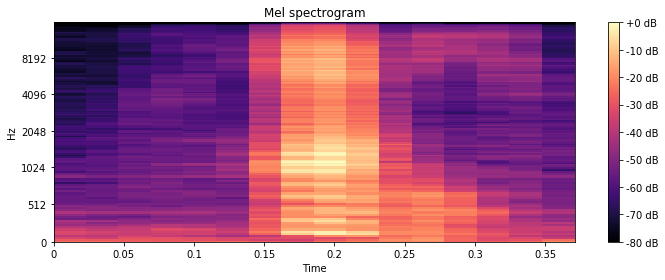

In [5]:
plt.figure(figsize=(10, 4))

librosa.display.specshow(librosa.power_to_db(mel,
                                             ref=np.max),
                                             y_axis='mel', fmax=16000,
                                             x_axis='time')

plt.colorbar    (format='%+2.0f dB')
plt.title       ('Mel spectrogram')
plt.tight_layout()

In [6]:
np.shape(mel)

(128, 16)

In [7]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)

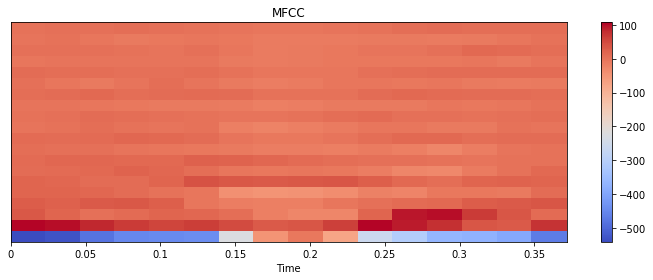

In [8]:
plt.figure(figsize=(10, 4))

librosa.display.specshow(mfcc, x_axis='time')

plt.colorbar    ()
plt.title       ('MFCC')
plt.tight_layout()

In [9]:
def log_specgram(path, window_size=20, step_size=10, eps=1e-10):
    sample_rate, audio = wavfile.read(path)
    
    nperseg  = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size   * sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                    fs       = sample_rate,
                                    window   = 'hann'     ,
                                    nperseg  = nperseg    ,
                                    noverlap = noverlap   ,
                                    detrend  = False       )
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [10]:
freqs, times, spectrogram = log_specgram('../data/speech_commands/happy/3ab9ba07_nohash_0.wav')

In [11]:
data   = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title = 'Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies'   , range=freqs),
    xaxis = dict(title='Time'          , range=times),
    zaxis = dict(title='Log amplitude'              ),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [12]:
y.shape

(8000,)

In [6]:
def get_noisey_audio(y):
    y_noise = y.copy()
    
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05 * np.random.uniform() * np.amax(y_noise)
    y_noise   = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
    
    return y_noise

In [7]:
def get_slow_audio(y):
    y_pitch_speed_slow = y.copy()
    
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac     = 1.0  * length_change
    
    tmp = np.interp(np.arange(0,len(y_pitch_speed_slow),speed_fac),np.arange(0,len(y_pitch_speed_slow)),y_pitch_speed_slow)
    
    minlen = min(y_pitch_speed_slow.shape[0], tmp.shape[0])
    
    y_pitch_speed_slow *= 0
    y_pitch_speed_slow[0:minlen] = tmp[0:minlen]
    
    return y_pitch_speed_slow

def get_fast_audio(y):
    y_pitch_speed_fast = y.copy()
    
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac     = 1.0  / length_change
    
    tmp = np.interp(np.arange(0,len(y_pitch_speed_fast),speed_fac),np.arange(0,len(y_pitch_speed_fast)),y_pitch_speed_fast)

    minlen = min(y_pitch_speed_fast.shape[0], tmp.shape[0])

    y_pitch_speed_fast *= 0
    y_pitch_speed_fast[0:minlen] = tmp[0:minlen]
    
    return y_pitch_speed_fast

In [8]:
y_tap, sr_tap = librosa.load('../data/speech_commands/_background_noise_/exercise_bike.wav', sr=8000)

def get_background_noise_audio(y):
    ytap_cut = y_tap[sr_tap:sr_tap * 2]

    combined_waves = np.zeros([sr_tap,])

    for i in range(0, sr_tap):
        average = (ytap_cut[i] + y[i]) / 2.0
        combined_waves[i] = average

    return combined_waves

In [9]:
def get_normalized_mel(y):
    mel   = librosa.feature.melspectrogram(y=y, sr=sr)
                
    mel_min = min(mel.min(axis=0))
    mel_max = max(mel.max(axis=0))
    
    denom = mel_max - mel_min
    if denom == 0.0 or np.isnan(denom):
        return None
    
    mel_norm = (mel - mel_min) / (mel_max - mel_min)
    mel_norm = np.expand_dims(mel_norm, axis=-1)
    
    return mel_norm

In [10]:
ipd.Audio(y, rate=sr) 

In [11]:
y_noise = get_noisey_audio(y)
ipd.Audio(y_noise, rate=sr)

In [12]:
exercise_y = get_background_noise_audio(y)
ipd.Audio(exercise_y, rate=sr) 

In [13]:
asdsad = get_slow_audio(y)
ipd.Audio(asdsad, rate=sr) 

In [14]:
y_fast = get_fast_audio(y)
ipd.Audio(y_fast, rate=sr) 

In [15]:
y_fast_excercise = get_background_noise_audio(y_fast)
ipd.Audio(y_fast_excercise, rate=sr) 

In [16]:
y_slow_excercise = get_background_noise_audio(asdsad)
ipd.Audio(y_slow_excercise, rate=sr) 

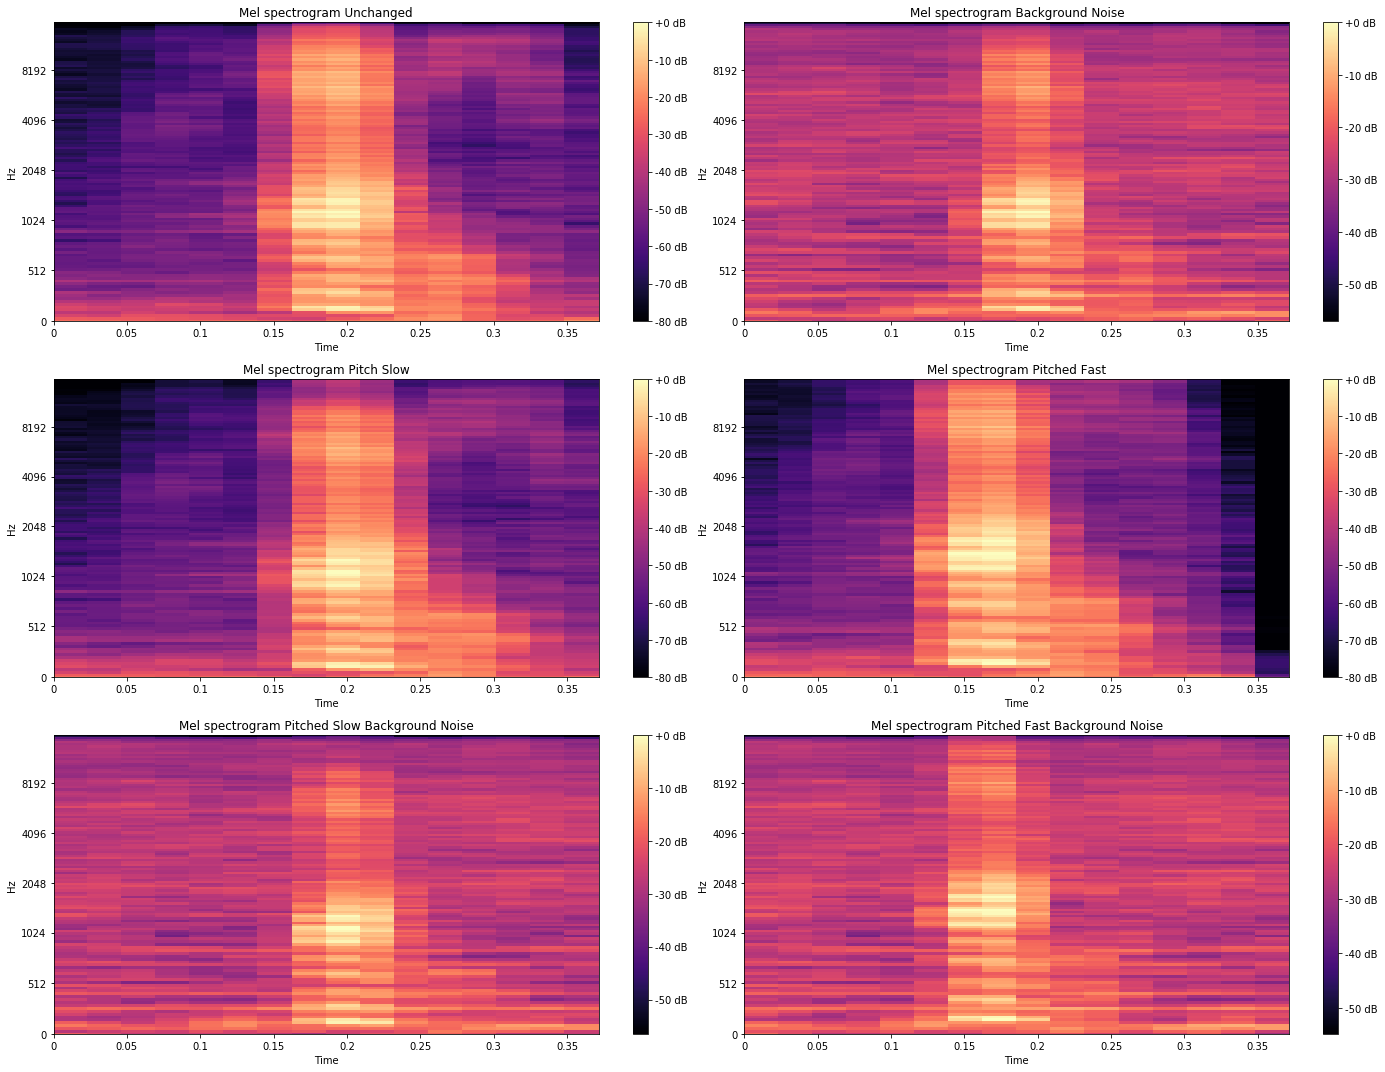

In [17]:
mels = []

mels.append(librosa.feature.melspectrogram(y=y,                sr=sr))
mels.append(librosa.feature.melspectrogram(y=exercise_y,       sr=sr))
mels.append(librosa.feature.melspectrogram(y=asdsad,           sr=sr))
mels.append(librosa.feature.melspectrogram(y=y_fast,           sr=sr))
mels.append(librosa.feature.melspectrogram(y=y_slow_excercise, sr=sr))
mels.append(librosa.feature.melspectrogram(y=y_fast_excercise, sr=sr))

titles = []

titles.append('Unchanged'                    )
titles.append('Background Noise'             )
titles.append('Pitch Slow'                   )
titles.append('Pitched Fast'                 )
titles.append('Pitched Slow Background Noise')
titles.append('Pitched Fast Background Noise')

fig=plt.figure(figsize=(20, 15))

columns = 2
rows    = 3

for i, mel in enumerate(mels):
    fig.add_subplot(rows, columns, i + 1)
    
    librosa.display.specshow(librosa.power_to_db(mel,
                                             ref=np.max),
                                             y_axis='mel', fmax=16000,
                                             x_axis='time')
    plt.colorbar    (format='%+2.0f dB')
    plt.title       ('Mel spectrogram ' + titles[i])
    plt.tight_layout()
    
plt.show()

In [18]:
class Training_Example:
    def __init__(self, mel, label, known):
        self.mel      = mel
        self.encoding = []
        
        self.encoding.append(known)
            
        for value in label:
            self.encoding.append(value)

In [39]:
def load_data_set(path, num_labels):
    training_examples = []
    test_examples     = []

    count = 0
    index = 0

    for directory in os.listdir(path):
        label = directory
        
        if os.path.isdir(path + '/' + directory) and directory != '_background_noise_':
            num_examples = 0
            for wavFile in os.listdir(path + '/' + directory):
                examples = []
                y, sr = librosa.load(path + '/' + directory + '/' + wavFile, sr=8000)
                
                if y.shape[0] != sr:
                    y = np.append(y, [0] * (sr - len(y)))
                    
                y_slow            = get_slow_audio(y)
                y_fast            = get_fast_audio(y)
                y_background      = get_background_noise_audio(y     )
                y_background_slow = get_background_noise_audio(y_slow)
                y_background_fast = get_background_noise_audio(y_fast)
                
                mels = []
                
                mels.append(get_normalized_mel(y                ))
                mels.append(get_normalized_mel(y_fast           ))
                mels.append(get_normalized_mel(y_slow           ))
                mels.append(get_normalized_mel(y_background     ))
                mels.append(get_normalized_mel(y_background_slow))
                mels.append(get_normalized_mel(y_background_fast))
                
                for mel in mels:
                    if mel is not None:
                        example = Training_Example(mel, np.eye(num_labels)[index] if count % 2 != 0 else np.zeros(15), 1.0 if count % 2 != 0 else 0.0)
                        num_examples += 1
                        
                        if num_examples < 500:
                            test_examples.append(example)
                        else:
                            training_examples.append(example)
                            
                #if num_examples > 5:
                #    break
                      
            #print(index)
            
            if count % 2 != 0:
                index += 1
                
            count += 1
                
            print(directory + ': ' + str(num_examples))
            
    return training_examples, test_examples

In [40]:
training_examples, test_examples = load_data_set('../data/speech_commands', 15)

bed: 10278
bird: 10383
cat: 10398
dog: 10476
down: 14154
eight: 14112
five: 14142
four: 14232
go: 14232
happy: 10452


KeyboardInterrupt: 

In [22]:
training_examples[45].encoding

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [142]:
print(len(training_examples))
print(len(test_examples    ))

373353
14970


In [23]:
def getBatch(examples, batch, batch_size):
    start = batch       * batch_size
    end   = (batch + 1) * batch_size
    
    freqs  = []
    labels = []
    
    if end >= len(examples):
        end = len(examples)
    
    for i in range(start, end):
        freqs.append(examples [i].mel  )
        labels.append(examples[i].encoding)
    
    return freqs, labels

In [ ]:
def simple_training_model(training_examples, numCategories, learning_rate = 1e-5, num_epochs = 5, batch_size = 32):
    ops.reset_default_graph()
    m = len(training_examples)
    
    model_input  = tf.placeholder(dtype = tf.float32, shape = (None, 128, 16, 1),        name = 'mel_input'   )
    labels       = tf.placeholder(dtype = tf.float32, shape = (None, numCategories + 1), name = 'labels'      )
    is_training  = tf.placeholder(dtype = tf.bool,                                       name = 'is_training' )
    
    with tf.device('cpu:0'):
        output = tf.layers.conv2d       (model_input, filters=64, kernel_size=(7, 3), padding='SAME', activation=tf.nn.elu)
        output = tf.layers.max_pooling2d(output, pool_size=(1, 3), strides=(1,1),     padding='SAME')
        
        output = tf.layers.conv2d       (output,      filters=128, kernel_size=(1, 7), padding='SAME', activation=tf.nn.elu)
        output = tf.layers.max_pooling2d(output, pool_size=(1, 4), strides=(1,1),      padding='SAME')
        
        output = tf.layers.conv2d       (output,      filters=128, kernel_size=(1, 7), padding='SAME', activation=tf.nn.elu)
        output = tf.layers.max_pooling2d(output, pool_size=(1, 4), strides=(1,1),      padding='SAME')
        
        output = tf.layers.conv2d       (output,      filters=256, kernel_size=(1, 10), padding='VALID', activation=tf.nn.elu)
        output = tf.layers.conv2d       (output,      filters=512, kernel_size=(1, 2), activation=tf.nn.elu)
        
        output = tf.layers.flatten(output)
        output = tf.layers.dropout(output, training=is_training)
        output = tf.layers.dense  (output, numCategories + 1, activation=tf.identity)
        output = tf.cond(is_training, lambda: output, lambda: tf.nn.softmax(output))
        
        output = tf.identity(output, name="final_output")
        
        cost_recognized = tf.losses.mean_squared_error(labels[..., 0], output[..., 0])
        cost_softmax    = tf.losses.softmax_cross_entropy(onehot_labels=labels[..., 1:numCategories + 1], logits=output[:, 1:numCategories + 1])
        #cost_softmax    = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=output)
        cost            = tf.reduce_mean(cost_softmax + cost_recognized)
        optimizer       = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        
    saver = tf.train.Saver()
    
    init  = tf.global_variables_initializer()

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    sess.run(init)
    
    tf.train.write_graph(sess.graph.as_graph_def(), './tmp/input_model', 'input_word_recognition.pbtxt', True)

    for epoch in range(num_epochs):
        epoch_cost = 0
        num_batches = (int)(m / batch_size)
        
        shuffle(training_examples)
        for batch in range(num_batches):
            freqs, l   = getBatch(training_examples, batch, batch_size)
            
            _, batch_cost = sess.run([optimizer, cost], feed_dict = { model_input : freqs, labels : l, is_training : True})
            epoch_cost += batch_cost / num_batches
    
        #if epoch % 10 == 0:
        print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        print ()
        print ("---------------------------------------------")
        print ()
        saver.save(sess, './tmp_' + str(epoch) + '/word_recognition.ckpt')
            
    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
    print ()
    print ("---------------------------------------------")
    print ()
    saver.save(sess, './tmp_final/word_recognition.ckpt')

In [ ]:
simple_training_model(training_examples, numCategories = 15, num_epochs=10, batch_size = 16)

In [30]:
def getAccuracy(examples):
    correct   = 0
    incorrect = 0
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./tmp_final/word_recognition.ckpt.meta')
        saver.restore(sess, './tmp_final/word_recognition.ckpt')
        graph = tf.get_default_graph()
        out = graph.get_tensor_by_name('final_output:0')
        
        for example in examples:
            test_input = example.mel
            test_input = np.reshape(test_input, (1, 128, 16, 1))
            
            encoding = sess.run(out, feed_dict = { 'mel_input:0' : test_input, 'is_training:0' : False })
            
            sencoding = encoding[0]
            
            guess = np.where(sencoding              == np.amax(sencoding))[0][0]
            actual= np.where(example.label == np.amax(example.label))[0][0]
            
            if guess == actual:
                correct += 1
            else:
                incorrect += 1
                
    accuracy = correct / (correct + incorrect)
    print(accuracy)

In [31]:
getAccuracy(training_examples)

INFO:tensorflow:Restoring parameters from ./tmp_final/word_recognition.ckpt
0.9988101447385578


In [32]:
getAccuracy(test_examples)

INFO:tensorflow:Restoring parameters from ./tmp_final/word_recognition.ckpt
0.7203087885985748


In [135]:
#index = 3
#
#ops.reset_default_graph()
#
#training_example = training_examples[index]
#test_input = training_example.mel
#
#test_input = np.reshape(test_input, (1, 128, 16, 1))
#with tf.Session() as sess:
#    saver = tf.train.import_meta_graph('./tmp_test/word_recognition.ckpt.meta')
#    saver.restore(sess, './tmp_test/word_recognition.ckpt')
#    graph = tf.get_default_graph()
#    
#    out = graph.get_tensor_by_name('final_output:0')
#    
#    encoding = sess.run(out, feed_dict = { 'mel_input:0' : test_input, 'is_training:0' : False })
#    
#sencoding = encoding[0]
#print(np.where(sencoding              == np.amax(sencoding))[0][0])
#print(np.where(training_example.label == np.amax(training_example.label))[0][0])